In [9]:
import InternalLibrary.SimulatorPackage as SP
import InternalLibrary.StatisticalFunctions as SF
import torch
from sbi import utils as utils
from numpy.random import uniform
import numpy as np
from sbi.inference import SNPE
from sbi.utils.user_input_checks import process_prior
from sbi import analysis as analysis
from InternalLibrary.SimulatorPackage import Simulator_noGPU
from Utils_functions import get_theta_from_prior

In [35]:
stats_batch_iterator = SF.statistics_from_file(max_files_to_analyze=2)

In [36]:
for batch in stats_batch_iterator:
    for stat in batch:
        s, t = SF.select_summary_statistics(stat,["Cxx"])

TypeError: not a sequence

In [32]:
# Limits for the parameters
prior_limits = [[1.5e4, 4e4], 
                [1e4, 140e4], 
                [3e-3, 16e-3], 
                [1.5e-2, 30e-2], 
                [1e-3, 6e-3], 
                [2e-2, 20e-2], 
                [0.5, 6], 
                [5.5, 15.5], 
                [1, 530]]
prior_limits = np.array(prior_limits)
prior_box = utils.torchutils.BoxUniform(low=torch.tensor(prior_limits[:, 0]), high=torch.tensor(prior_limits[:, 1]))
theta = [uniform(prior_limits[i][0], prior_limits[i][1], size=(1, 1)) for i in range(len(prior_limits))]
prior, num_parameters, prior_returns_numpy = process_prior(prior_box)

In [33]:
infer = SNPE(prior=prior)
for batch in stats_batch_iterator:
    for stat in batch:
        s, theta_torch = SF.select_summary_statistics(stat,["Cxx"])
        infer.append_simulations(theta_torch, s)

/Users/jacopocarotenuto/miniconda3/envs/CompLab/lib/python3.9/site-packages/sbi/utils/sbiutils.py:49: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1760.)
  zx = (x - x.mean(0)) / x.std(0)


In [34]:
density_estimator = infer.train()
posterior = infer.build_posterior(density_estimator)

 Neural network successfully converged after 85 epochs.

In [10]:
def get_centroids_from_samples(samples):
    mean_params = np.array([])
    mode_params = np.array([])

    for i in range(9):
        # Retrive the samples for the parameter i
        params = samples[:,i].numpy()
        # Compute the mean
        mean_params = np.concatenate((mean_params, [np.mean(params)]))
        # Compute the mode
        hist, bin_edges = np.histogram(params, bins=int(np.sqrt(params.shape[0])))
        max_index = np.argmax(hist)
        mode = (bin_edges[max_index] + bin_edges[max_index+1])/2
        mode_params = np.concatenate((mode_params, [mode]))

    mean_params = mean_params.reshape(9, 1, 1)
    mode_params = mode_params.reshape(9, 1, 1)
    return mean_params, mode_params

In [12]:
dt = 1e-6# The time step size for the simulation. This is the amount of time that passes in the model for each step of the simulation
Sample_frequency = 25_000 # The sampling frequency. This is the number of samples that are recorded per unit time
DeltaT = 1/Sample_frequency # The sampling period. This is the amount of time that passes in the model between each sample that is recorded
TotalT = 5 # The total time for the simulation. This is the total amount of time that the simulation is intended to represent
n_sim = int(2e3)
t_corr = TotalT/50

In [11]:
samples = posterior.sample((int(1e5),), x=s)
mean_params, mode_params = get_centroids_from_samples(samples)

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

In [15]:
# Simulate the observation(s)
theta_true, theta_torch_true, prior_box_true = get_theta_from_prior(prior_limits, n_sim=1)
x_trace_true, f_trace_true, y_trace_true = Simulator_noGPU(dt, DeltaT, TotalT, theta_true)

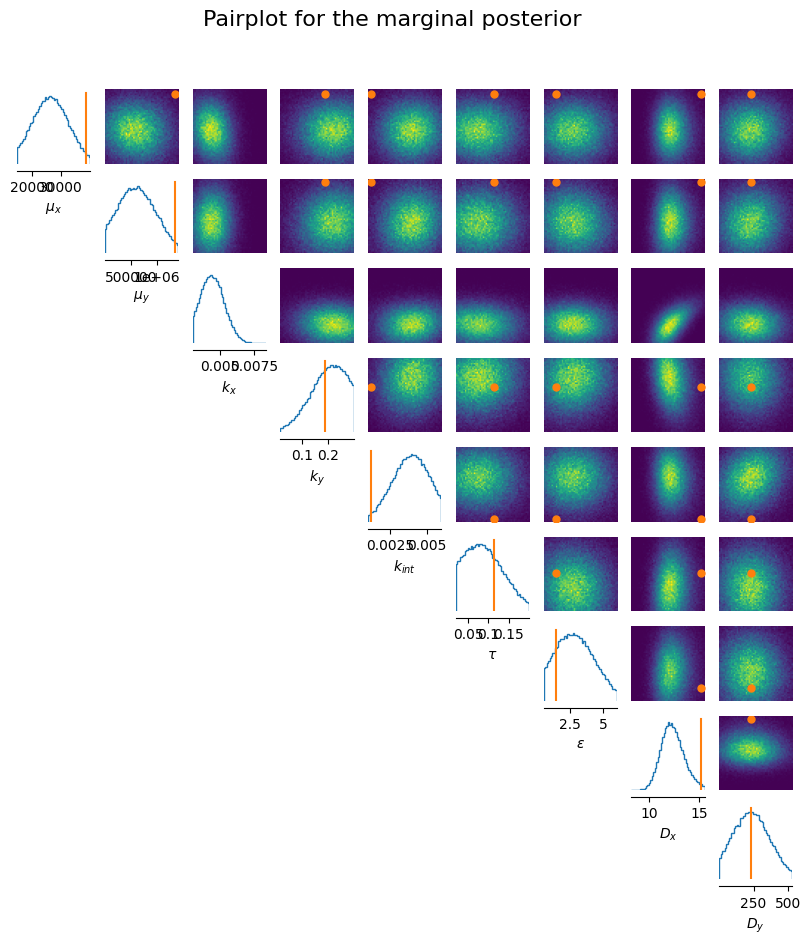

In [17]:
# Pairplot
label_theta = [r"$\mu_x$", r"$\mu_y$", r"$k_x$", r"$k_y$", r"$k_{int}$", r"$\tau$", r"$\varepsilon$", r"$D_x$", r"$D_y$"]
import matplotlib as mpl
_ = analysis.pairplot(samples, points=[theta_torch_true],  figsize=(10, 10), 
                      title = "Pairplot for the marginal posterior",
                      labels=label_theta)